# Урок 5. Случайный лес

### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [1]:
import random
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

In [3]:
data, labels = datasets.make_classification(n_samples=100,
                                            n_features = 2, n_informative = 2, 
                                            n_classes = 2, n_redundant=0, 
                                            n_clusters_per_class=1, random_state=33)

data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size = 0.3, random_state=2)

In [4]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction   

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [17]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [26]:
# Визуализация

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx, yy, data_gr # список массивов координатных сеток

In [19]:
n_trees_list = [1, 3, 10, 50]
n = len(n_trees_list)

my_forests = []
train_accuracies = []
test_accuracies = []

for n_trees in n_trees_list:
    my_forest_i = random_forest(data_train, labels_train, n_trees)
    
    train_answers = tree_vote(my_forest_i, data_train)
    test_answers = tree_vote(my_forest_i, data_test)
    
    train_accuracy = accuracy_metric(labels_train, train_answers)
    test_accuracy = accuracy_metric(labels_test, test_answers)
    
    my_forests.append(my_forest_i)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

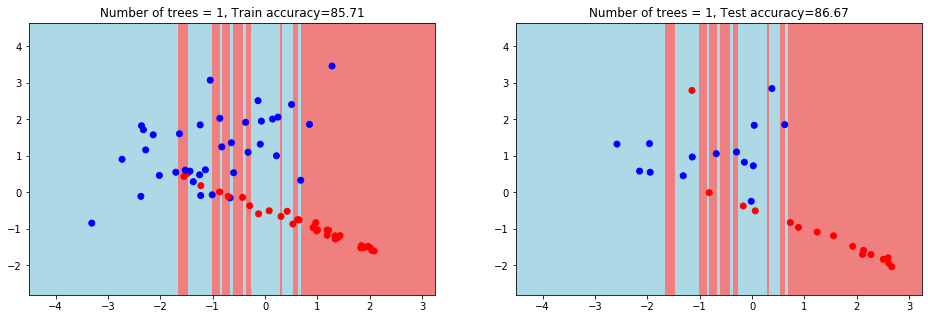

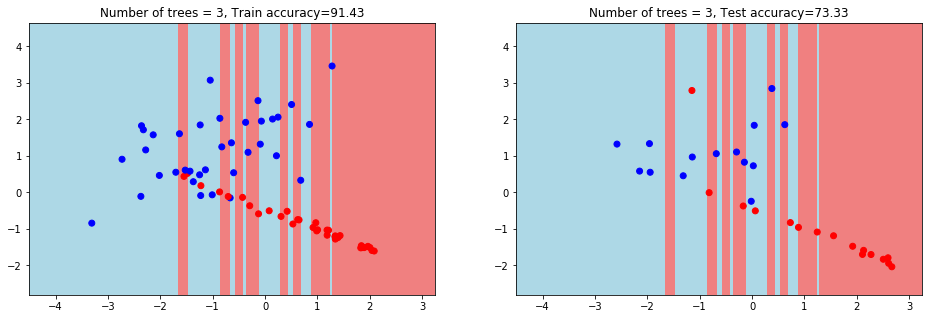

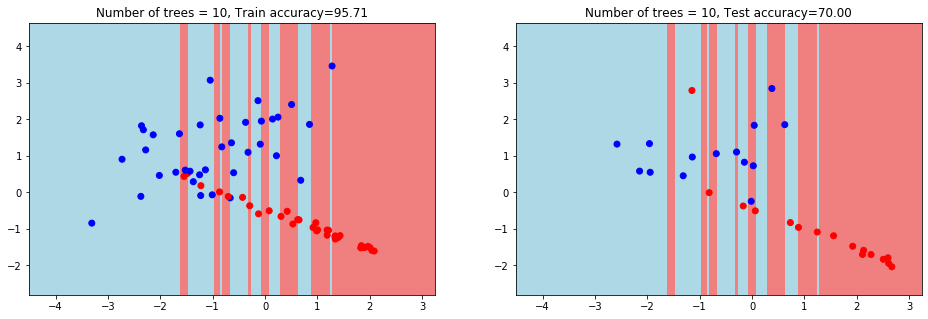

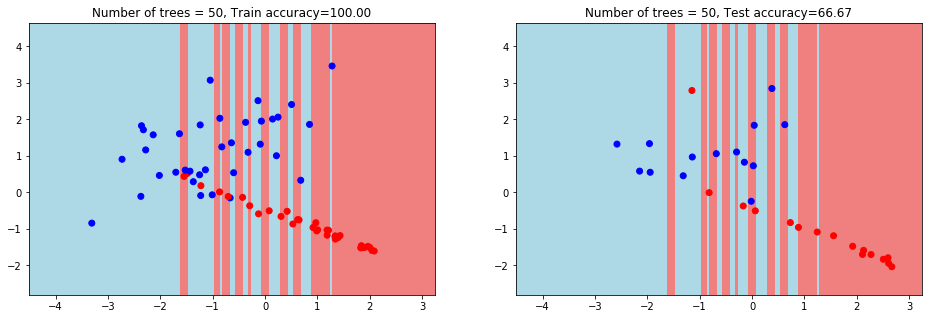

In [27]:
xx, yy, gr = get_meshgrid(data_train)

for i, my_forest in enumerate(my_forests):
    plt.figure(figsize = (16, 5))
    
    # график обучающей выборки
    plt.subplot(1,2,1)
    mesh_predictions = np.array(tree_vote(my_forest, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(data_train[:, 0], data_train[:, 1], c = labels_train, cmap = colors)
    plt.title(f'Number of trees = {n_trees_list[i]}, Train accuracy={train_accuracies[i]:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(data_test[:, 0], data_test[:, 1], c = labels_test, cmap = colors)
    plt.title(f'Number of trees = {n_trees_list[i]}, Test accuracy={test_accuracies[i]:.2f}')

### 2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем

В данном конкретном случае даже при небольшом кол-ве деревьев вид гиперплосткости достаточно непростой. Переобучение наблюдается уже при n_trees=3, а увелечение деревьев только ухудшает результат. На этих данных модель работает плохо, увеличение числа наблюдений улучшает ситуацию.

### 3. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [28]:
def get_bootstrap_idxs(data, n_trees):
    n_samples = len(data)
    return np.random.randint(0, n_samples, size = (n_trees, n_samples))

In [29]:
def get_oof(idxs):
    all_idxs = set(range(len(idxs[0])))
    oof_idxs = [list(all_idxs - set(idx)) for idx in idxs]
    return np.array(oof_idxs)

In [32]:
def random_forest_oof(data, labels, n_trees):
    forest, scores = [], []
    bootstrap_idxs = get_bootstrap_idxs(data, n_trees)
    oof = get_oof(bootstrap_idxs)
    
    for idx in bootstrap_idxs:
        b_data, b_labels = data[idx], labels[idx]
        tree = build_tree(b_data, b_labels)
        forest.append(tree)
        
    for idx in oof:
        oof_data, oof_labels = data[idx], labels[idx]
        for tree in forest:
            y_pred = predict(oof_data, tree)
            score = accuracy_metric(oof_labels, y_pred)
        scores.append(score)
    
       
    return forest, scores

In [50]:
my_forests = []

for n_trees in n_trees_list:
    my_forest_i, scores_i = random_forest_oof(data, labels, n_trees)
    
    answers = tree_vote(my_forest_i, data)
    
    train_accuracy = accuracy_metric(labels, answers)
    
    my_forests.append(my_forest_i)
    print(f'Number of trees = {n_trees}, Train accuracy = {train_accuracy:.2f}, OOB = {np.mean(scores_i):.2f}')


Number of trees = 1, Train accuracy = 90.00, OOB = 74.36
Number of trees = 3, Train accuracy = 95.00, OOB = 87.01
Number of trees = 10, Train accuracy = 99.00, OOB = 83.77
Number of trees = 50, Train accuracy = 100.00, OOB = 93.64


Видно, что оценка работы модели по методу Out-of-bag значительно выше, чем при использовании отложенной выборки.

### 4. (На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy и сравнить результаты построения леса по Шеннону и Gini.

In [56]:
def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p > 0:
            impurity -= p * np.log2(p)
        
    return impurity

In [57]:
# Расчет качества

def quality(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [58]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_entropy = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [59]:
my_forests = []

for n_trees in n_trees_list:
    my_forest_i, scores_i = random_forest_oof(data, labels, n_trees)
    
    answers = tree_vote(my_forest_i, data)
    
    train_accuracy = accuracy_metric(labels, answers)
    
    my_forests.append(my_forest_i)
    print(f'Number of trees = {n_trees}, Train accuracy = {train_accuracy:.2f}, OOB = {np.mean(scores_i):.2f}')

Number of trees = 1, Train accuracy = 88.00, OOB = 68.42
Number of trees = 3, Train accuracy = 96.00, OOB = 89.18
Number of trees = 10, Train accuracy = 98.00, OOB = 88.95
Number of trees = 50, Train accuracy = 100.00, OOB = 88.43


Оценка на тестовых данных уменьшилась по сравнению с критерием Джини, но значение более стабильно при изменении количества деревьев